In order to successfully complete this assignment you need to participate both individually and in groups during class on **Wednesday March 13th**.


# In-Class Assignment: CUDA Alternatives

<table>
  <tr>
    <td><img src="https://lh3.googleusercontent.com/-fOzCZpGK6m8/AAAAAAAAAAI/AAAAAAAAAAw/owm58nzDGWQ/w360-h203-p-rw/photo.jpg"></td>
    <td>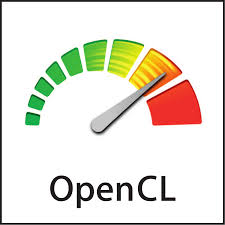</td>
  </tr>
</table>

### Agenda for today's class (70 minutes)

</p>

1. (40 minutes) Finish 1D CUDA Wave Example
1. (30 minutes) Pre-class Review


----

# 3. Finish 1D CUDA Wave Example


### Serial Example (Slow)

In [ ]:
%%writefile NCode/wave_serial.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

int main(int argc, char ** argv) {
    int nx = 5000;
    int nt = 1000000;
    int i,it;
    double x[nx];
    double y[nx];
    double v[nx];
    double dvdt[nx];
    double dt;
    double dx;
    double max,min;
    double dx2inv;
    double tmax;

    max=10.0;
    min=0.0;
    dx = (max-min)/(double)(nx);
    x[0] = min;
    for(i=1;i<nx;i++) {
        x[i] = min+(double)i*dx;
    }
    x[nx-1] = max;
    tmax=10.0;
    dt= (tmax-0.0)/(double)(nt);

    
    for (i=0;i<nx;i++)  {
        y[i] = exp(-(x[i]-5.0)*(x[i]-5.0));
        v[i] = 0.0;
        dvdt[i] = 0.0;
    }
    
    dx2inv=1.0/(dx*dx);
    
    for(it=0;it<200000;it++) {
        for(i=1;i<nx-1;i++)
            dvdt[i]=(y[i+1]+y[i-1]-2.0*y[i])*(dx2inv);

        for(i=1; i<nx-1; i++)  {
            v[i] = v[i] + dt*dvdt[i];
            y[i] = y[i] + dt*v[i];
        }

    }

    for(i=0; i<nx; i++) {
        printf("%g, %g\n",x[i],y[i]);
    }
    
    return 0;
}


In [ ]:
!g++ -o serial NCode/wave_serial.c

In [ ]:
!time ./serial > temp.txt

In [ ]:
import csv

x = []
y = []
with open('temp.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        x.append(float(row[0]))
        y.append(float(row[1]))

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt
plt.plot(x,y)

### CUDA Version

In [ ]:
%%writefile NCode/wave_cuda_tiled.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>
#define CUDA_CALL(x) {cudaError_t cuda_error__ = (x); if (cuda_error__) { fprintf(stderr, "CUDA error: " #x " returned \"%s\"\n", cudaGetErrorString(cuda_error__)); fflush(stderr); exit(cuda_error__); } }

const int BLOCKDIM=1024;

__global__ void accel_update(double* d_dvdt, double* d_y, int nx, double dx2inv)
{
	int i = (blockDim.x * blockIdx.x + threadIdx.x)+1;
	if (i < nx-1)
        d_dvdt[i] = (d_y[i+1]+d_y[i-1]-2.0*d_y[i])*dx2inv;
}

__global__ void pos_update(double * d_dvdt, double * d_y, double * d_v, int nx, double dt)
{
	int i = (blockDim.x * blockIdx.x + threadIdx.x)+1;
    if (i < nx-1) {
        d_v[i] = d_v[i] + dt*d_dvdt[i];
        d_y[i] = d_y[i] + dt*d_v[i];
    }  
}

const int LOCALDIM=BLOCKDIM+2;
__global__ void tile_accel_update(double* d_dvdt, double* d_y, int nx, double dx2inv)
{
	int i = blockDim.x * blockIdx.x + threadIdx.x;
    int mx = blockDim.x * (blockIdx.x + 1) - 1;
    
    //Allocate local memory
    __shared__ double y_local[LOCALDIM];  
    
    //Copy to local index
    int local_idx = threadIdx.x+1; 
    y_local[local_idx] = d_y[i]; 
    
    //fill in edges
    if(threadIdx.x == 0) {
        y_local[0] = d_y[i-1];  
        y_local[LOCALDIM-1] = d_y[mx]; 
    }    
    
    //Check for edge case
    if(i == 0 || i > nx-2)  
        d_dvdt[i] = 0;
    else {
        d_dvdt[i]=(y_local[local_idx+1]+y_local[local_idx-1]-2.0*y_local[local_idx])*(dx2inv); 
        d_dvdt[i] = (d_y[i+1]+d_y[i-1]-2.0*d_y[i])*dx2inv;
    }
}

__global__ void all(double* d_dvdt, double* d_y,  double * d_v, int nx, double dx2inv, double dt, int nt)
{
	int i = blockDim.x * blockIdx.x + threadIdx.x;
    int mx = blockDim.x * (blockIdx.x + 1) - 1;
    
    //Allocate local memory
    __shared__ double y_local[LOCALDIM];  
    
    //Copy to local index
    int local_idx = threadIdx.x+1;  
    y_local[local_idx] = d_y[i]; 
    
    //fill in edges
    if(threadIdx.x == 0) {
        y_local[0] = d_y[i-1];  
        y_local[LOCALDIM-1] = d_y[mx]; 
    }    
    
    //Check for edge case
    if(i == 0 || i > nx-2)  
        d_dvdt[i] = 0;
    else {
        for(int it=0;it<nt;it++) {
            //fill in edges
            d_dvdt[i]=(y_local[local_idx+1]+y_local[local_idx-1]-2.0*y_local[local_idx])*(dx2inv); 

            d_v[i] = d_v[i] + dt*d_dvdt[i];
            y_local[local_idx] = y_local[local_idx] + dt*d_v[i];
            
        }
    }
    d_y[i] = y_local[local_idx];
}

    
int main(int argc, char ** argv) {
    int nx = 5000;
    int nt = 1000000;
    int i,it;
    double x[nx];
    double y[nx];
    double v[nx];
    double dvdt[nx];
    double dt;
    double dx;
    double max,min;
    double dx2inv;
    double tmax;

    max=10.0;
    min=0.0;
    dx = (max-min)/(double)(nx);
    x[0] = min;
    for(i=1;i<nx;i++) {
        x[i] = min+(double)i*dx;
    }
    x[nx-1] = max;
    tmax=10.0;
    dt= (tmax-0.0)/(double)(nt);

    for (i=0;i<nx;i++)  {
        y[i] = exp(-(x[i]-5.0)*(x[i]-5.0));
        v[i] = 0.0;
        dvdt[i] = 0.0;
    }
    
    dx2inv=1.0/(dx*dx);

    double *d_x, *d_y, *d_v, *d_dvdt;
    cudaError_t err; 
    int nBytes = nx*sizeof(double);
    CUDA_CALL(cudaMalloc((void **)&d_x,nBytes));
    CUDA_CALL(cudaMalloc((void **)&d_y,nBytes));
    CUDA_CALL(cudaMalloc((void **)&d_v,nBytes));
    CUDA_CALL(cudaMalloc((void **)&d_dvdt,nBytes));
    
   fprintf(stderr, "dt = %f, dx = %f\n", dt,dx);
   CUDA_CALL(cudaMemcpy(d_y,y,nBytes,cudaMemcpyHostToDevice));
   CUDA_CALL(cudaMemcpy(d_v,v,nBytes,cudaMemcpyHostToDevice));
   CUDA_CALL(cudaMemcpy(d_dvdt,dvdt,nBytes,cudaMemcpyHostToDevice));
    
   dx2inv=1.0/(dx*dx);
    
   int block_size=BLOCKDIM;
   int block_no = (nx-2)/block_size;
   dim3 dimBlock(block_size,1,1);
   dim3 dimGrid(block_no,1,1);

    /******************************/
    for(it=0;it<200000;it++) {
        
        accel_update<<<dimGrid, dimBlock>>>(d_dvdt, d_y, nx, dx2inv);
        //tile_accel_update<<<dimGrid, dimBlock>>>(d_dvdt, d_y, nx, dx2inv);
        
        err = cudaGetLastError();
        if (err != cudaSuccess) {
             fprintf(stderr, "\n\nError: %s\n\n", cudaGetErrorString(err)); fflush(stderr); exit(err);   
        }
        
        pos_update<<<dimGrid, dimBlock>>>(d_dvdt, d_y, d_v,nx, dt);
        
         err = cudaGetLastError();
        if (err != cudaSuccess) {
             fprintf(stderr, "\n\nError: %s\n\n", cudaGetErrorString(err)); fflush(stderr); exit(err);   
        }
    }
    /******************************/
        
    CUDA_CALL(cudaMemcpy(y,d_y,nBytes,cudaMemcpyDeviceToHost));

    //printf("x, y\n");
    for(i=0; i<nx; i++) {
        printf("%g, %g\n",x[i],y[i]);
    }
    
    cudaFree(d_dvdt);
    cudaFree(d_y);
    cudaFree(d_v);

    return 0;
}


In [ ]:
#Compile Cuda
!nvcc -std=c++11 -o wave_cuda_tiled NCode/wave_cuda_tiled.cu

In [ ]:
#Run Example
!time ./wave_cuda_tiled > temp2.txt

In [ ]:
import csv

x = []
y = []
with open('temp2.txt') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    line_count = 0
    for row in csv_reader:
        x.append(float(row[0]))
        y.append(float(row[1]))

In [ ]:
%matplotlib inline
import matplotlib.pylab as plt
plt.plot(x,y)

---
# 2. Pre-class Review

[0312--CUDA_Alternatives-pre-class-assignment](0228--CUDA_Memory-pre-class-assignment.ipynb)

As a class we will discuss the various alternatives to cuda and their pros and cons.

-----
### Congratulations, we're done!


**Course Resources:**
- [Syllabus](https://tinyurl.com/y75cnzam)
- [Preliminary Schedule](https://tinyurl.com/CMSE314-Schedule)
- [Git Repository](https://gitlab.msu.edu/colbrydi/cmse401-s19)
- [Jargon Jar and Command History](https://tinyurl.com/CMSE314-JargonJar) 



&#169; Copyright 2019,  Michigan State University Board of Trustees